# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
!pip install mlflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random
import math 
from sklearn.metrics import roc_curve, auc
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input
from keras.models import Sequential, Model
import mlflow
import mlflow.keras

**LOAD DATA**

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-08-26 20:06:26--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  92.8MB/s    in 2.4s    

2021-08-26 20:06:28 (92.8 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
# Unzipping Data
!gunzip flower_photos.tgz

gzip: flower_photos.tar already exists; do you wish to overwrite (y or n)? y


In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [ ]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [ ]:
len(images) # Number of images

3670

In [ ]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [ ]:
image_size = 224 # Setting the size of the images

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [ ]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [ ]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [ ]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**VGGNet**

In [ ]:
# Instanciate and empty model
model = Sequential()
# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same',input_shape=(image_size,image_size,3))) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU', padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fith convolutional layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# 1st dense layer
model.add(Flatten()) 
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5)) 
model.add(Activation('PReLU'))
# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization()) 
model.add(Activation('PReLU'))
# Output softmax layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      3213056   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 64)      839744    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 128)       475264    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 128)      

In [ ]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=60, verbose=1, shuffle=True)

2021/08/26 20:06:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/utils/autologging_utils/safety.py:239: UserWarning: Logging to MLflow failed: Yaml file '/content/mlruns/0/meta.yaml' does not exist."
2021/08/26 20:06:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Yaml file '/content/mlruns/0/meta.yaml' does not exist.


Epoch 1/60
92/92 [==============================] - 68s 701ms/step - loss: 1.5241 - accuracy: 0.4066 - precision: 0.4840 - recall: 0.2722 - val_loss: 1.6080 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
92/92 [==============================] - 62s 672ms/step - loss: 1.2631 - accuracy: 0.5298 - precision: 0.5851 - recall: 0.4233 - val_loss: 1.6154 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
92/92 [==============================] - 62s 672ms/step - loss: 1.1316 - accuracy: 0.5764 - precision: 0.6544 - recall: 0.4832 - val_loss: 1.6251 - val_accuracy: 0.1751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
92/92 [==============================] - 62s 671ms/step - loss: 1.0964 - accuracy: 0.5914 - precision: 0.6574 - recall: 0.5053 - val_loss: 1.5857 - val_accuracy: 0.2818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/60
92/92 [==============================] - 62s 670ms/step -

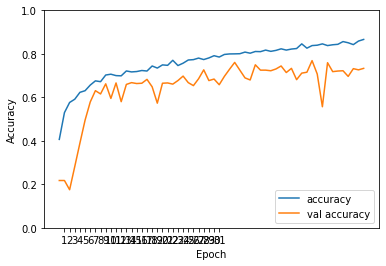

In [ ]:
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,32)))
plt.ylim([0, 1])
plt.legend(loc='lower right')

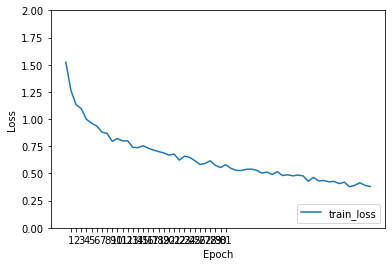

In [ ]:
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,32)))
plt.ylim([0, 2])
plt.legend(loc='lower right')

THe higher the AUC, the better performance of the model at distinguishing between the positives and negatives classes

**Final Scores**

Accuracy = $\frac{(TP+TN)}{(TP+FP+TN+FN)}$

Precision = $\frac{TP}{(TP+FP)}$

Recall =$\frac{TP}{(TP+FN)}$

**Plot Evaluation**

In [ ]:
def plot_example(X, y, y_pred=None):
# Create figure with 3 x 3 sub-plots.
  fig, axes = plt.subplots(3, 3)
  fig.set_size_inches(18,10)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  X, y = X[:9, ..., 0], y[:9]
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X[i])
    # Show true and predicted classes.
    if y_pred is None:
      xlabel = "True: {0}".format(y[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])
    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
  plt.show()

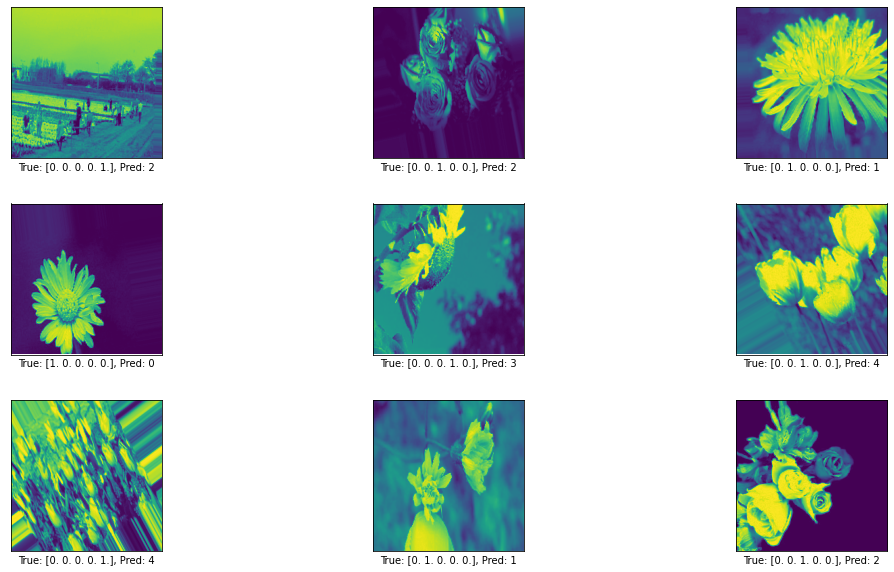

In [ ]:
model = tf.keras.models.load_model('07_model.h5')
#%matplotlib inline
# Make prediction
predictions = model.predict(x_test)
# retrieve prediction indices
pred_y = flower_gen_test.class_indices(np.argmax(predictions, axis=1))
# Plot some examples with model predictions
plot_example(x_test, y_test, pred_y)